## TIME PROFILING EXPERIMENTS

We have 3 variants - 

1. PSO
2. GSO (non-parallel)
3. PGSO (parallel GSO)

We are going to test their speed and cpu-utilization.

We are also going to show the amhdals curve for speedup. We argue that we are not interested in the speedup as we increase the number of cores. Rather how much of the search space we can efficiently discover with the increase in the number of spawned threads.

**Highlights**

+ Our code on a single thread is the fastest among all implementations
+ We outperform PSO ans sequential GSO on all benchmarks
+ As we increase the number of cores we are able to find better solutions

In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from pgso.test_functions import *
from pgso.gso import GSO as PGSO
from pgso.benchmark import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Construct particle class

In [3]:
#dependencies
import random
import math
import copy # for array copying
import sys

class Particle:
    def __init__(self,x0, num_dimensions):
        self.position_i=[]          # particle position
        self.velocity_i=[]          # particle velocity
        self.pos_best_i=[]          # best position individual
        self.err_best_i=-1          # best error individual
        self.err_i=-1               # error individual
        self.num_dimensions = num_dimensions
        
        for i in range(0, self.num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evaluate current fitness
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # check to see if the current position is an individual best
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # update new particle velocity
    def update_velocity(self,pos_best_g):
        w=0.5       # constant inertia weight (how much to weigh the previous velocity)
        c1=1        # cognative constant
        c2=2        # social constant

        for i in range(0, self.num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # update the particle position based off new velocity updates
    def update_position(self,bounds):
        for i in range(0, self.num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # adjust maximum position if necessary
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # adjust minimum position if neseccary
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]

# PSO

In [4]:
def PSO(costFunc,bounds,maxiter, swarm_init):
    global num_dimensions

    num_dimensions=len(swarm_init[0])
    err_best_g=-1                   # best error for group
    pos_best_g=[]                   # best position for group
    num_particles = len(swarm_init)
    # establish the swarm
    swarm = [Particle(position, num_dimensions) for position in swarm_init]
    # begin optimization loop
    i=0
    while i < maxiter:
        #print i,err_best_g
        # cycle through particles in swarm and evaluate fitness
        for j in range(0,num_particles):
            swarm[j].evaluate(costFunc)

            # determine if current particle is the best (globally)
            if swarm[j].err_i < err_best_g or err_best_g == -1:
                pos_best_g=list(swarm[j].position_i)
                err_best_g=float(swarm[j].err_i)

        # cycle through swarm and update velocities and position
        for j in range(0,num_particles):
            swarm[j].update_velocity(pos_best_g)
            swarm[j].update_position(bounds)
        i+=1

    # print final results
    #print ('\n')
    #print (pos_best_g,' , ', err_best_g)
    return pos_best_g, err_best_g

In [5]:
# GLOBAL SEttiNGS
initial=[5,5]                             # initial starting location [x1,x2...]
bounds = [[-1000, 1000], [-1000, 1000]]   # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
num_particles = 75
max_iter = 1500

def test_PSO(M, bounds, num_particles, max_iter, costfunc):
    subswarm_bests = []
    for i in range(M):
        swarm_init = [np.random.uniform(-10,10, 2) for _ in range(num_particles)]
        subswarm_best,_ = PSO(costfunc,bounds,max_iter, swarm_init=swarm_init)
        subswarm_bests.append(subswarm_best)
    best_position, best_error = PSO(costfunc, bounds, max_iter, swarm_init=subswarm_bests)
    return best_position, best_error

In [6]:
%timeit test_PSO(5, bounds, num_particles, max_iter, rastrigin)

8.07 s ± 171 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Plot cpu usage graph for PSO
Y - axis is cpu usage in %

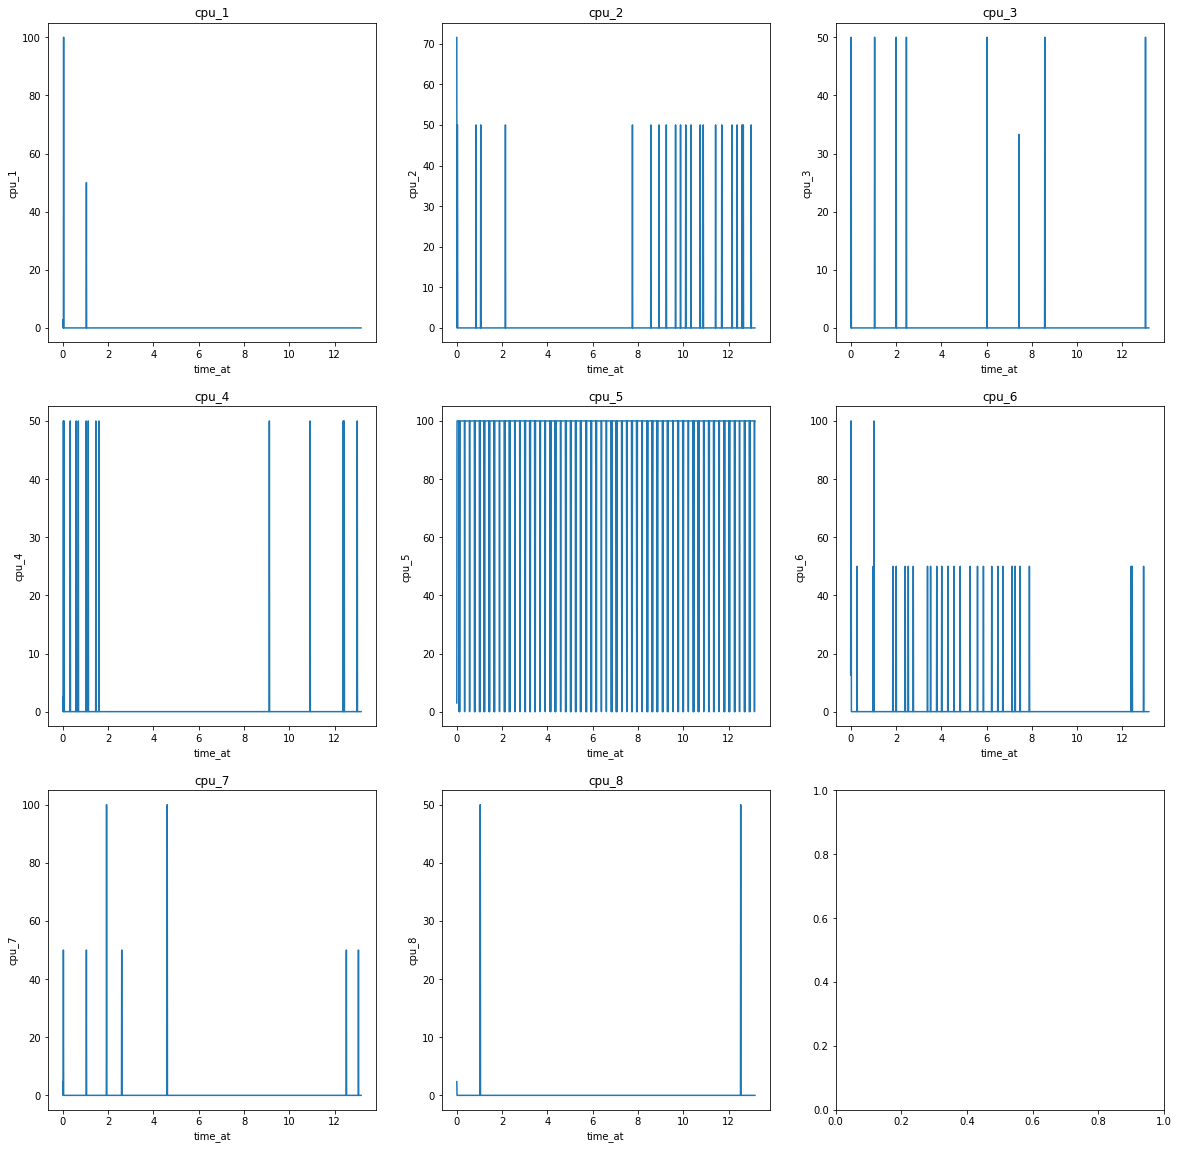

In [7]:
cpu_percent, time_at, top_prcnt = monitor(test_PSO, bounds, num_particles, max_iter, rastrigin, 5)
multiple_cpu_plot(top_prcnt, time_at)

# GSO

Galactic Swarm Optimization without parallelism

In [6]:
def GSO(M, bounds, num_particles, max_iter, costfunc):
    subswarm_bests = []
    dims = len(bounds)
    lb = bounds[0][0] 
    ub = bounds[0][1] 
    for i in range(M):
        #initial= np.random.uniform(-10,10, 2)               # initial starting location [x1,x2...]         
        swarm_init = [np.random.uniform(lb, ub, dims) for _ in range(num_particles)]
        subswarm_best,_ = PSO(costfunc,bounds,max_iter, swarm_init=swarm_init)
        subswarm_bests.append(subswarm_best)
    best_position, best_error = PSO(costfunc, bounds, max_iter, swarm_init=subswarm_bests)
    return best_position, best_error

In [9]:
%timeit GSO(5, bounds, num_particles, max_iter, rastrigin)

13.8 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Plot cpu usage graph for GSO

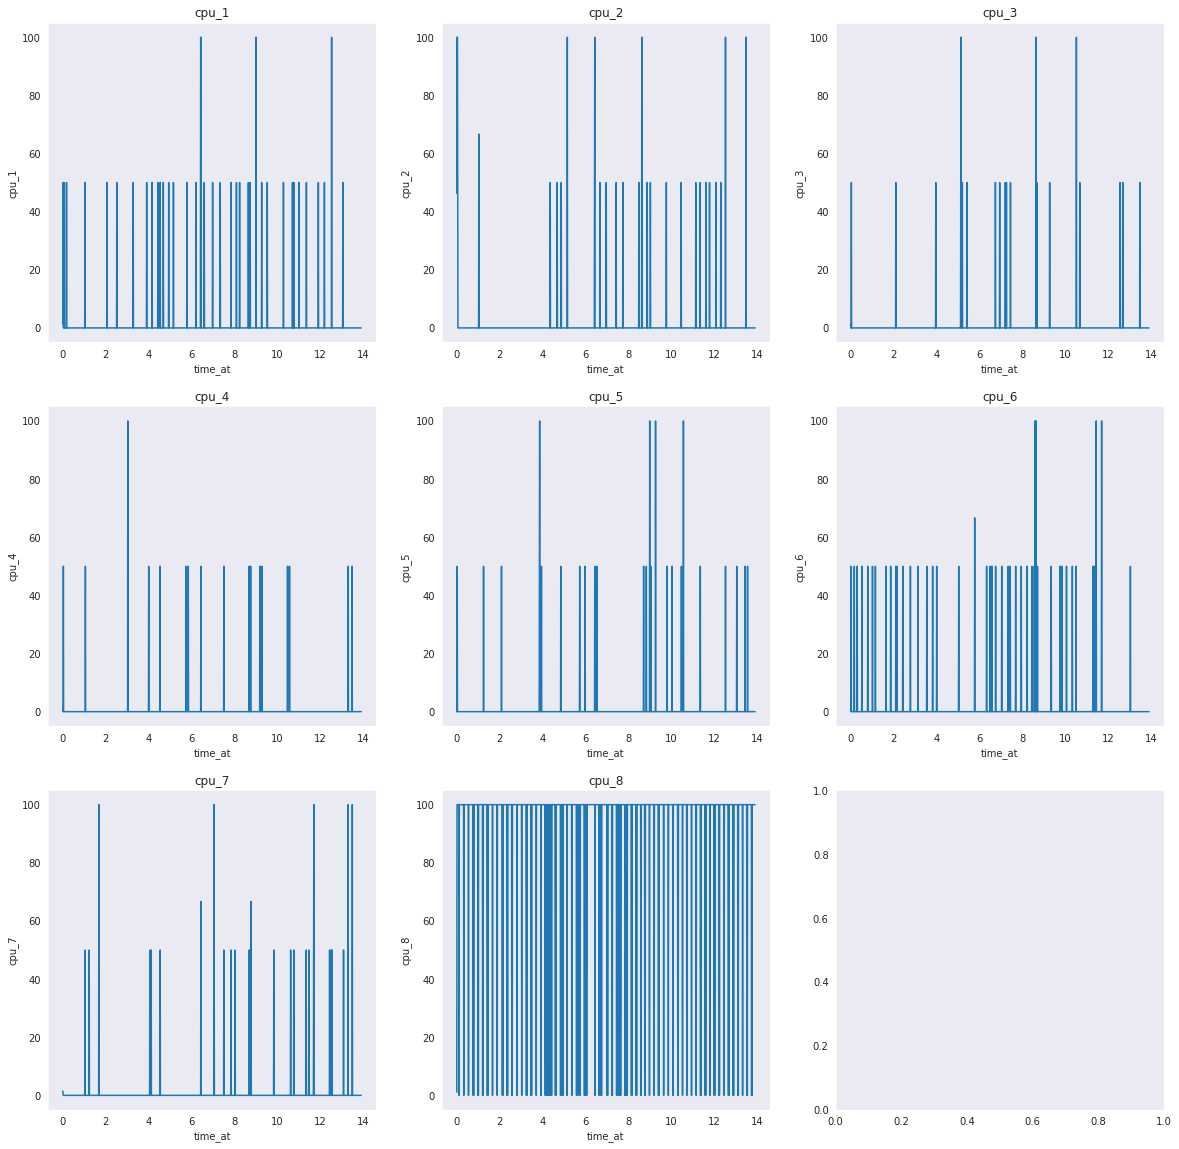

In [10]:
cpu_percent, time_at, top_prcnt = monitor(GSO, bounds, num_particles, max_iter, rastrigin, 5)
multiple_cpu_plot(top_prcnt, time_at)

# Parallelized GSO

Now we will test how our new implementation fares against them

In [11]:
%timeit PGSO(1, bounds, num_particles, max_iter, rastrigin)

12.9 s ± 70.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see it is particularly **FASTEST** even on a single CPU. The real power of PGSO comes from the fact that we can utilize our full CPU capacity for exploring the search space like no other. As we increase the number of CPUs we will be guaranteed with a better solution trading off with a bit of speed.

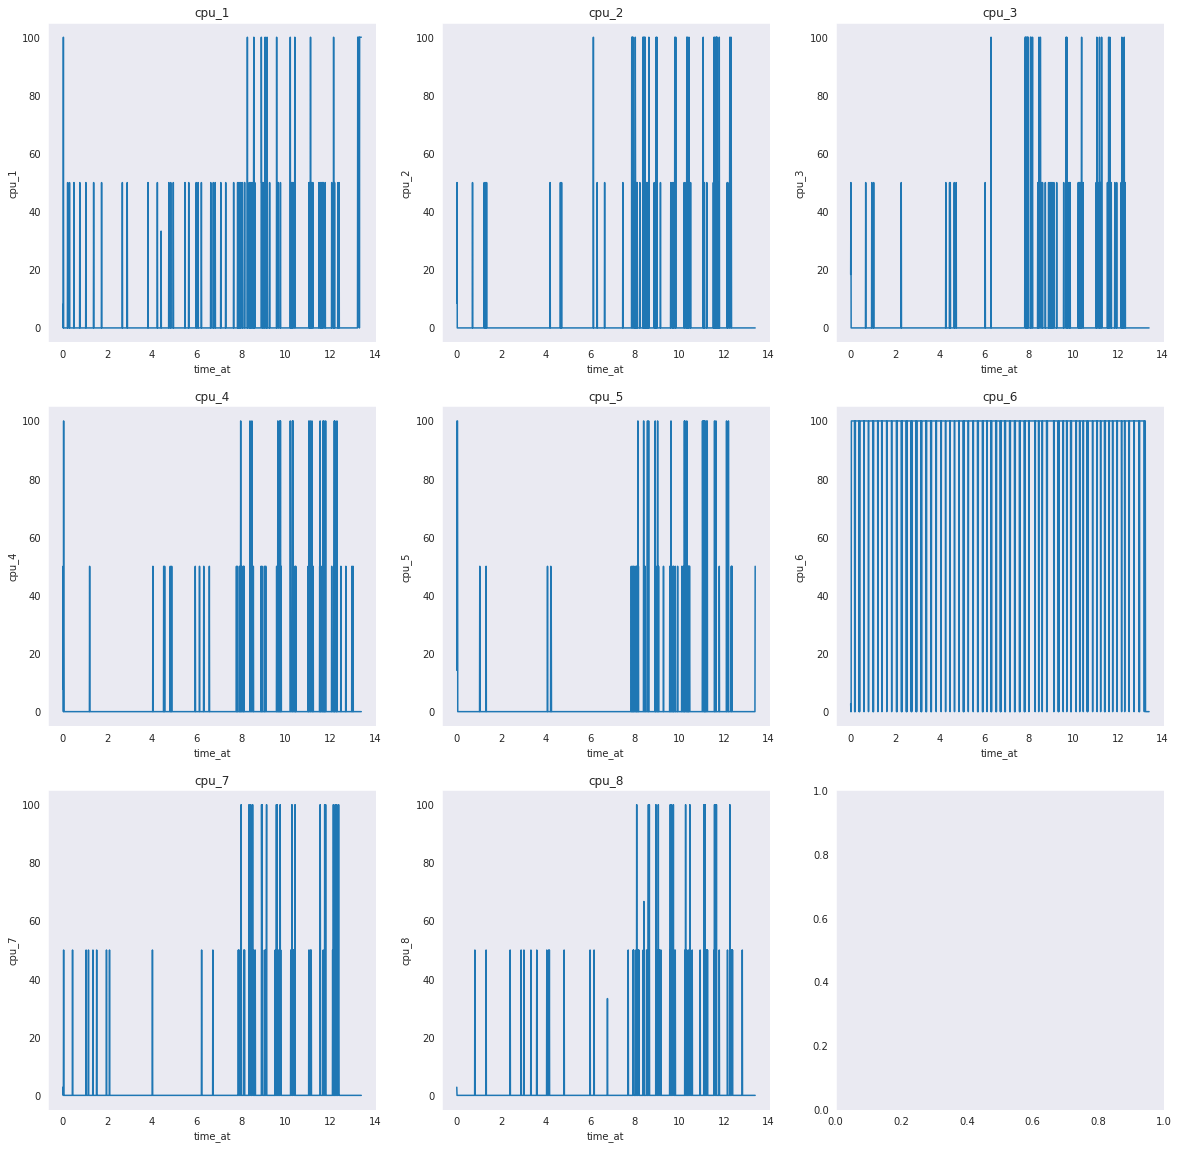

In [12]:
# 1 cpu test
cpu_percents, time_at, top_prcnt = monitor(PGSO, bounds, num_particles, max_iter, rastrigin, 1)
multiple_cpu_plot(top_prcnt, time_at)

# Testing All benchmark functions with PGSO spwaning 8 processes

In [13]:
list_of_benchmark_functions = [sphere, rosen, rastrigin, griewank, zakharov, nonContinuousRastrigin]
string_list = ["sphere", "rosen", "rastrigin", "griewank", "zakharov", "nonContinuousRastrigin"]

bounds = [[-100, 100], [-100, 100]]   # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
num_particles = 20
max_iter = 500

for costfun, stre in zip(list_of_benchmark_functions, string_list):
    best_pos, best_err = PGSO(8, bounds, num_particles, max_iter, costfun)
    print(stre," best position: ", best_pos, " best error: ", best_err)

sphere  best position:  [-1.15653952e-19  2.48066460e-19]  best error:  0.0
rosen  best position:  [0.99495864 1.05122347]  best error:  0.9949590570932898
rastrigin  best position:  [-1.35843176e-10 -8.35954051e-10]  best error:  0.0
griewank  best position:  [ 1.56490468e-09 -1.08337460e-08]  best error:  0.0
zakharov  best position:  [ 2.95537177e-24 -1.80678038e-25]  best error:  0.0
nonContinuousRastrigin  best position:  [-4.52851948e-10  2.70235658e-09]  best error:  0.0


In [14]:
%load_ext line_profiler
%lprun PGSO(8, bounds, num_particles, max_iter, costfun)

# Testing All Benchmark functions with GSO (NON - PARALLEL)

In [15]:
for costfun, stre in zip(list_of_benchmark_functions, string_list):
    if stre == 'rosen':
        continue
    best_pos, best_err = GSO(5, bounds, num_particles, max_iter, costfun)
    print(stre," best position: ", best_pos, " best error: ", best_err)

sphere  best position:  [2.9376718610164905e-56, -6.965114418467165e-55]  best error:  4.859911802196928e-109
rastrigin  best position:  [-0.9949586376781872, 5.310592802747126e-10]  best error:  0.9949590570932898
griewank  best position:  [-3.140022636143256, 4.438444476139403]  best error:  0.007396040334115006
zakharov  best position:  [1.3645497625115075e-54, -2.7120552918934345e-54]  best error:  1.3337248476065866e-107
nonContinuousRastrigin  best position:  [5.179959105876112e-10, 3.078467391182762e-09]  best error:  0.0


# Testing ALL Benchmark functions with PSO

In [16]:
for costfun, stre in zip(list_of_benchmark_functions, string_list):
    if stre == 'rosen':
        continue
    best_pos, best_err = test_PSO(5, bounds, num_particles, max_iter, costfun)
    print(stre," best position: ", best_pos, " best error: ", best_err)

sphere  best position:  [6.209550350481986e-56, 2.8140948280983635e-56]  best error:  4.647764525670091e-111
rastrigin  best position:  [1.4703110608156388e-09, 2.4626662253305465e-09]  best error:  0.0
griewank  best position:  [3.140022628179391, -4.438444475207315]  best error:  0.007396040334115006
zakharov  best position:  [-4.366066313855701e-53, 1.0927165559345742e-53]  best error:  2.144535481900055e-105
nonContinuousRastrigin  best position:  [3.6334848445867167e-10, 2.169338142060313e-09]  best error:  0.0


In [17]:
bounds = [[-1000, 1000], [-1000, 1000]]   # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
num_particles = 50
max_iter = 1000

GSO_time = %timeit -o GSO(5, bounds, num_particles, max_iter, rastrigin)

6.29 s ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
PGSO_time = %timeit -o PGSO(1, bounds, num_particles, max_iter, rastrigin)

5.83 s ± 168 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
TS_GSO = GSO_time.average

TP = list()
TP.append(PGSO_time.average)

speedup = list()
speedup.append(TS_GSO/TP[0])

In [21]:
PGSO_time_2 = %timeit -o PGSO(2, bounds, num_particles, max_iter, rastrigin)
TP_2 = PGSO_time_2.average
TP.append(TP_2)
speedup.append(TS_GSO/TP_2)

5.94 s ± 69.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
PGSO_time_4 = %timeit -o PGSO(4, bounds, num_particles, max_iter, rastrigin)
TP_4 = PGSO_time_4.average
TP.append(TP_4)
speedup.append(TS_GSO/TP_4)

6.13 s ± 8.11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
PGSO_time_6 = %timeit -o PGSO(6, bounds, num_particles, max_iter, rastrigin)
TP_6 = PGSO_time_6.average
TP.append(TP_6)
speedup.append(TS_GSO/TP_6)

8.69 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
PGSO_time_8 = %timeit -o PGSO(8, bounds, num_particles, max_iter, rastrigin)
TP_8 = PGSO_time_8.average
TP.append(TP_8)
speedup.append(TS_GSO/TP_8)

9.86 s ± 206 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


[HTML](file:///gail.html)

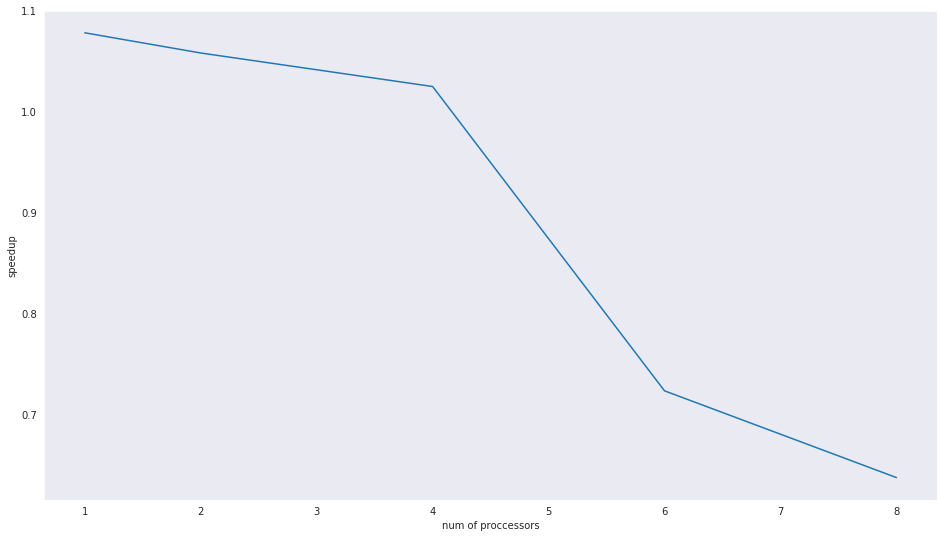

In [25]:
%matplotlib inline
plt.figure(figsize=(16,9))
ax = plt.gca()
ax.set_xlabel('num of proccessors')
ax.set_ylabel('speedup')
sns.lineplot(x=[1,2,4,6,8], y=speedup)

We can see that the speedup decrease with the increase in processors. This is couterintuitve right. Exactly.But we would like to argue that when we spawn more number of threads what we are expecting is that more number of swarms are exploring the search space. 

What that means is that when they talk together the overhead of time increases as we introduce more swarms. The benifit we get out of increasing the swarms is that we get a better solution than just using a single swarm. We show that in our out experiments below

In [26]:
output2 = PGSO(2, bounds, num_particles, max_iter, rastrigin)
output4 = PGSO(4, bounds, num_particles, max_iter, rastrigin)
output6 = PGSO(6, bounds, num_particles, max_iter, rastrigin)
output8 = PGSO(8, bounds, num_particles, max_iter, rastrigin)

In [28]:
print('\n','2 processors: ', output2, '\n', '4 processors: ', \
      output4, '\n', '6 processors: ', output6, '\n',\
     '8 processors: ', output8)


 2 processors:  (array([1.03571501e-09, 3.72677960e-09]), 0.0) 
 4 processors:  (array([ 2.40331428e-10, -2.39544973e-09]), 0.0) 
 6 processors:  (array([ 8.95486286e-10, -2.35244970e-09]), 0.0) 
 8 processors:  (array([8.60236051e-10, 7.05218625e-10]), 0.0)


It looks like all of them are performing well, lets now increase the bounds and move to a more challenging function to make things little more intersting

In [29]:
bounds = [[-1000, 1000], [-1000, 1000]]

In [32]:
output2 = PGSO(2, bounds, num_particles, max_iter, rosen)
output4 = PGSO(4, bounds, num_particles, max_iter, rosen)
output6 = PGSO(6, bounds, num_particles, max_iter, rosen)
output8 = PGSO(8, bounds, num_particles, max_iter, rosen)

In [33]:
print('\n','2 processors: ', output2, '\n', '4 processors: ', \
      output4, '\n', '6 processors: ', output6, '\n',\
     '8 processors: ', output8)


 2 processors:  (array([0.99495864, 0.92053756]), 0.9949590570932898) 
 4 processors:  (array([0.99495864, 0.98418887]), 0.9949590570932898) 
 6 processors:  (array([0.99495864, 0.999354  ]), 0.9949590570932898) 
 8 processors:  (array([0.99495864, 1.01438957]), 0.9949590570932898)


The correct solution for getting Rosens right is [1, 1] we can see as we increase the number of cores we are progressing more towards this [1,1] value

In [7]:
bounds = [[-100, 100], [-100, 100]]   # input bounds [(x1_min,x1_max),(x2_min,x2_max)...]
num_particles = 20
max_iter = 500

In [15]:
unimodal_functions = [exponential, powellsumfcn, sum_of_squares, schfewel_220, schwefel_222, griewank, zakharov, sphere]
unimodal_strings = ['exponential', ' powell sum function', ' sum_of_squares', ' schfewel 2.20', ' schwefel 2.22', ' griewank', ' zakharov', ' sphere']

multimodal_functions = [nonContinuousRastrigin, ackley, rastrigin, rosen]
multimodal_strings = ['nonContinuousRastrigin', 'ackley', 'rastrigin', 'rosen'] 

PGSO GSO and PSO testing With above settings

and

taking average of 10 runs for every function

Ignoring position storing only best error

# Running Unimodal function first

In [9]:
def get_result(algo, functions, strings):
    modal_dict = dict()
    for func, stre in zip(functions, strings):
        for i in range(10):
            if i == 0:
                modal_dict[stre] = 0
            modal_dict[stre] += algo(5, bounds, num_particles, max_iter, func)[1]
        modal_dict[stre] = modal_dict[stre]/10
    return modal_dict

## PSO

In [17]:
get_result(test_PSO, unimodal_functions, unimodal_strings)

{'exponential': -0.9999990804955926,
 ' powell sum function': 2.1983186598990584e-51,
 ' sum_of_squares': 1.326968364852877e-107,
 ' schfewel 2.20': 1.21925032467482e-54,
 ' schwefel 2.22': 1.2131214508375074e-53,
 ' griewank': 0.004437624200468992,
 ' zakharov': 1.6446975994168213e-107,
 ' sphere': 4.999360357004948e-107}

## GSO

In [11]:
get_result(GSO, unimodal_functions, unimodal_strings)

{'exponential': -0.9,
 ' powell sum function': 1.10637880207623e-51,
 ' sum_of_squares': 5.00638231622719e-106,
 ' schfewel 2.20': 5.290235363938148e-53,
 ' schwefel 2.22': 1.7566638389996873e-53,
 ' griewank': 0.007396040321675979,
 ' zakharov': 6.988699310611373e-105,
 ' sphere': 2.409672689741487e-104}

## PGSO

In [12]:
get_result(PGSO, unimodal_functions, unimodal_strings)

{'exponential': 0.0,
 ' powell sum function': 0.0,
 ' sum_of_squares': 0.0,
 ' schfewel 2.20': 0.0,
 ' schwefel 2.22': 0.0,
 ' griewank': 0.0,
 ' zakharov': 0.0,
 ' sphere': 0.0}

## True Results

In [13]:
{'exponential': 0.0,
 ' powell sum function': 0.0,
 ' sum_of_squares': 0.0,
 ' schfewel 2.20': 0.0,
 ' schwefel 2.22': 0.0,
 ' griewank': 0.0,
 ' zakharov': 0.0,
 ' sphere': 0.0}

{'exponential': 0.0,
 ' powell sum function': 0.0,
 ' sum_of_squares': 0.0,
 ' schfewel 2.20': 0.0,
 ' schwefel 2.22': 0.0,
 ' griewank': 0.0,
 ' zakharov': 0.0,
 ' sphere': 0.0}

# Running MultiModal

## PSO

In [18]:
get_result(test_PSO, multimodal_functions, multimodal_strings)

{'nonContinuousRastrigin': 0.09949590570932898,
 'ackley': 4.440892098500626e-16,
 'rastrigin': 0.0,
 'rosen': 1.482213235540342e-07}

## GSO

In [19]:
get_result(GSO, multimodal_functions, multimodal_strings)

{'nonContinuousRastrigin': 0.0,
 'ackley': 7.993605777301127e-16,
 'rastrigin': 0.19899181141865796,
 'rosen': 2.302735721718835}

## PGSO

In [20]:
get_result(GSO, multimodal_functions, multimodal_strings)

{'nonContinuousRastrigin': 0.0,
 'ackley': 4.440892098500626e-16,
 'rastrigin': 0.09949590570932898,
 'rosen': 1.4917011055510243}